In [1]:
%load_ext autoreload
%autoreload 2
from keras.applications.vgg16 import VGG16

import numpy as np
import os
import pandas as pd
from sklearn.metrics import accuracy_score

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img, img_to_array
from keras.models import load_model
from keras.preprocessing import image
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import keras

from sklearn.utils import class_weight

from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

import models.simpleConv as simpleConv
import models.crazyNet as crazyNet
import models.finalModels as finalModels
# import models.newModel as newModel
import keras.applications as kap
# import models.betterConv as betterConv
from imgaug import augmenters as iaa

import h5py
from imgaug import augmenters as iaa
from keras.utils import np_utils

import pickle

import utils
import preprocessing as pp
pp.init()

allTrainingFolders = [x for x in os.listdir(pp.trainPath) if x.startswith('n')]
np.random.shuffle(allTrainingFolders)
num = 25
trainingFolders = allTrainingFolders[0:num]

# with open('trainingFolderOrder.text', 'w') as f:
#     f.write(" ".join(trainingFolders))

  


Using TensorFlow backend.


Checking to make sure output directories are created....done


In [2]:
pp.trainPath = 'E:\\SCHOOL CMPS 240\\ILSVRC\Data\\CLS-LOC\\train'

allTrainingFolders = [x for x in os.listdir(pp.trainPath) if x.startswith('n')]
np.random.shuffle(allTrainingFolders)
num = 25
trainingFolders = allTrainingFolders[0:num]

trainingFolders

['n02319095',
 'n03982430',
 'n01980166',
 'n02317335',
 'n02017213',
 'n03995372',
 'n07753592',
 'n02107908',
 'n04208210',
 'n03085013',
 'n01981276',
 'n02110063',
 'n04065272',
 'n03372029',
 'n02091244',
 'n03527444',
 'n01697457',
 'n07615774',
 'n07693725',
 'n03272010',
 'n02137549',
 'n02727426',
 'n06785654',
 'n02113799',
 'n01739381']

In [ ]:
arr = [1, 2, 3, 4, 5, 6, 1]
encoder2 = LabelBinarizer()
##MAKE SURE classLabels is set to ALL the folders you will train on, even if doing in batches
encoder2 = encoder.fit(arr)

In [7]:
arr =[pp.translateID(x) for x in trainingFolders]

# for x in (arr):
#     print(x)

[x.split(',')[0] for x in arr]

['boa constrictor',
 'cradle',
 'guacamole',
 'trifle',
 'pencil sharpener',
 'black grouse',
 'wardrobe',
 'beach wagon',
 'miniature schnauzer',
 'tench',
 'trailer truck',
 'odometer',
 'sarong',
 'mailbag',
 'upright',
 'radio telescope',
 'snowmobile',
 'jeep',
 'honeycomb',
 'hen',
 'scoreboard',
 'confectionery',
 'Irish setter',
 'tiger',
 'computer keyboard']

In [3]:
with open (os.path.join('output', 'trainingFolderOrderDicks25.text'), 'rb') as fp:     
    trainingFolders = pickle.load(fp)

In [ ]:


parse =False
train = True
saveModel = False
includeAugmented = False
onlyAugmented = False

augments = [iaa.Rot90(1), iaa.Rot90(2), iaa.Fliplr(1), iaa.Flipud(1), iaa.Noop(), iaa.Dropout((0.01, 0.1), per_channel=0.5), 
            iaa.ContrastNormalization((0.5, 2.0), per_channel=0.5), iaa.PerspectiveTransform(scale=(0.01, 0.1))]
# augments = []
h5filename = '{0}-RANDcrazy25FINALreal.h5'.format(num)
h5file = os.path.join(pp.h5Path, h5filename)

if parse:
    if os.path.isfile(os.path.join(pp.h5Path, h5filename)):
        os.remove(os.path.join(pp.h5Path, h5filename))
    pp.parseImages(trainingFolders, h5filename)
#     pp.shuffleH5(h5file)
    #write to text file
    with open(os.path.join('output', 'trainingFolderOrderDicks25.text'), 'wb') as fp:     
        pickle.dump(trainingFolders, fp)
    
#read back    
with open (os.path.join('output', 'trainingFolderOrderDicks25.text'), 'rb') as fp:     
    trainingFolders = pickle.load(fp)
    
encoder = LabelBinarizer()
##MAKE SURE classLabels is set to ALL the folders you will train on, even if doing in batches
encoder = encoder.fit(trainingFolders)

h5db = h5py.File(h5file, 'r')

x_val = h5db['x_val'][:]
y_val = h5db['y_val'][:]

y_val = [k.decode('utf-8') for k in y_val]

y_val = encoder.transform(y_val)
val_data = (np.array(x_val), np.array(y_val))

h5db.close()
    
#NOTE: KEEP BATCH SIZE = # of all folders for now because we need to shuffle H5. 


filepath=os.path.join(pp.outputModelPath, "best-epoch-Swag2On25AUGS-{epoch:02d}-{val_acc:.2f}.hdf5")
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
#                   patience=20, min_delta=0.5)
# tb = keras.callbacks.TensorBoard(log_dir='./tensor-graph', histogram_freq=0,             
#                                  write_graph=False, write_images=False)

callbacks = [checkpoint]
epochs = 100
sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
# adam = keras.optimizers.Adam(lr=0.01, decay=1e-6)
model = finalModels.SwagNETv3(len(encoder.classes_))
# model = finalModels.SSD(len(encoder.classes_))
# model = crazyNet.build_model3(len(encoder.classes_))
# model = kap.nasnet.NASNetMobile(weights=None, include_top = True, pooling = 'avg', classes=50) 
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# model = load_model((os.path.join(pp.outputModelPath, 'best-epoch-CrazyEditedw5-37-0.68.hdf5')))

y_ints = [y.argmax() for y in y_val] 
class_weights = class_weight.compute_class_weight('balanced',                                                  
                                                np.unique(y_ints),                                                  
                                                y_ints)


batch_size = 20


##FIT MODEL
if train:
    train_generator = pp.DataGenerator3(h5file, trainingFolders, batch_size=batch_size, augmentations = augments, augmentReplace = False
                                       , augment_pct = 0.25, shuffle=True)
    val_generator = pp.DataGenerator3(h5file, trainingFolders, batch_size=batch_size, isValidation = True)
    print(len(train_generator))
    results = model.fit_generator(train_generator, validation_data = val_data, epochs=epochs, callbacks = callbacks, verbose=1,
                              use_multiprocessing=True, workers=4, class_weight = class_weights)
    with open(os.path.join(pp.trainhistory, 'Swag2AUGShistory.pkl'), 'wb') as file_pi:         
        pickle.dump(results.history, file_pi)

    if saveModel:
        count = 1
        outputName = ""
        while True:
            k = ''
            if includeAugmented:
                k = 'with-aug'
            if onlyAugmented:
                k = 'aug-only'
            s = pp.baseModelName.format(epoch, count, k) + ".h5" 
            if not s in os.listdir(pp.outputModelPath):         
                outputName = s         
                break     
            else:         
                count+=1 
        print(outputName)
        model.save(os.path.join(pp.outputModelPath, outputName))
        


In [5]:
with open(os.path.join(pp.trainhistory, 'Swag2augshistory.pkl'), 'wb') as file_pi:         
        pickle.dump(results.history, file_pi)

In [88]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 224, 224, 32) 2432        input_23[0][0]                   
__________________________________________________________________________________________________
bn1 (BatchNormalization)        (None, 224, 224, 32) 128         conv1[0][0]                      
__________________________________________________________________________________________________
elu1 (ELU)                      (None, 224, 224, 32) 0           bn1[0][0]                        
__________________________________________________________________________________________________
dropout_48

In [82]:
x_val

array([[[[0.08235294, 0.04313726, 0.00784314],
         [0.2627451 , 0.2627451 , 0.29411766],
         [0.23921569, 0.28235295, 0.25882354],
         ...,
         [0.07058824, 0.04705882, 0.        ],
         [0.01568628, 0.01176471, 0.03529412],
         [0.01960784, 0.01960784, 0.02745098]],

        [[0.18039216, 0.19215687, 0.14901961],
         [0.36862746, 0.27450982, 0.22745098],
         [0.49411765, 0.5137255 , 0.39607844],
         ...,
         [0.        , 0.00784314, 0.00784314],
         [0.01960784, 0.00392157, 0.00784314],
         [0.03529412, 0.00784314, 0.03529412]],

        [[0.15294118, 0.09411765, 0.07450981],
         [0.20392157, 0.19607843, 0.14901961],
         [0.28627452, 0.27058825, 0.25882354],
         ...,
         [0.        , 0.        , 0.        ],
         [0.1764706 , 0.1882353 , 0.14509805],
         [0.        , 0.        , 0.01568628]],

        ...,

        [[0.        , 0.02352941, 0.09411765],
         [0.13725491, 0.19607843, 0.18431373]

In [50]:
with open (os.path.join(pp.trainhistory, 'SSDhistory.pkl'), 'rb') as fp:     
    poop = pickle.load(fp)
    print(poop['val_acc'])

[0.0924788950924588, 0.0970836534112669, 0.07904835002452523, 0.06907137418172951, 0.12854950187737815, 0.1465848051211693, 0.1715272458889168, 0.19570222691970884, 0.14504988692809506, 0.20222563394906423, 0.2574827349069296, 0.2386799704280617, 0.20567920359161754, 0.2336914820492222, 0.21987720840794256, 0.18956255033349223, 0.1396776672884399, 0.18303914180029746, 0.24290099920717825, 0.2179585579705531, 0.3829623960467457, 0.30468150630810586, 0.33921719301300424, 0.31542594187070294, 0.3595548748158073, 0.4090560274863371, 0.3054489643982714, 0.35495011491882555, 0.43706830723621437, 0.21565617966885212, 0.38986953494302695, 0.4742901020398162, 0.5260936311765625, 0.5130468159971197, 0.4950115133365666, 0.513430545468195, 0.5299309298155954, 0.5237912532522508, 0.5790483499273189, 0.5157329239700267, 0.3534151986870323, 0.5019186495682504, 0.5368380672938076, 0.5214888734066843, 0.4044512687158054, 0.585571756579285, 0.5755947819144014, 0.29854182774345417, 0.4075211075378306, 0.

OSError: Unable to open file (unable to open file: name = 'output\image-h5\50-RANDcrazy25FINALreal.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [4]:
import preprocessing as pp
import os
import h5py

h5filename = '25-RANDcrazy25FINALreal.h5'
h5file = os.path.join(pp.h5Path, h5filename)
h5db = h5py.File(h5file, 'r') 
print(len(h5db['x_train']))
h5db.close()


10370


In [11]:
[pp.translateID(X) for X in trainingFolders]

['vine snake',
 'triceratops',
 'quail',
 'tiger shark, Galeocerdo cuvieri',
 'common newt, Triturus vulgaris',
 'house finch, linnet, Carpodacus mexicanus',
 'diamondback, diamondback rattlesnake, Crotalus adamanteus',
 'prairie chicken, prairie grouse, prairie fowl',
 'hornbill',
 'alligator lizard',
 'trilobite',
 'frilled lizard, Chlamydosaurus kingi',
 'Indian cobra, Naja naja',
 'chickadee',
 'magpie',
 'electric ray, crampfish, numbfish, torpedo',
 'goldfish, Carassius auratus',
 'horned viper, cerastes, sand viper, horned asp, Cerastes cornutus',
 'hen',
 'sulphur-crested cockatoo, Kakatoe galerita, Cacatua galerita',
 'bulbul',
 'terrapin',
 'black grouse',
 'black swan, Cygnus atratus',
 'hummingbird',
 'water ouzel, dipper',
 'ringneck snake, ring-necked snake, ring snake',
 'water snake',
 'African chameleon, Chamaeleo chamaeleon',
 'jay',
 'black widow, Latrodectus mactans',
 'night snake, Hypsiglena torquata',
 'axolotl, mud puppy, Ambystoma mexicanum',
 'box turtle, box 

In [7]:
model.save(os.path.join(pp.outputModelPath, '100epochsNewCrazy.hdf5'))

In [3]:
# model1 = load_model((os.path.join(pp.outputModelPath, 'best-epoch-Res25-100-0.63.hdf5')))
model1 = load_model((os.path.join(pp.outputModelPath, 'best-epoch-SSD25-37-0.53.hdf5')))
model2 = load_model((os.path.join(pp.outputModelPath, 'best-epoch-SSDACTUALOn25-30-0.61.hdf5')))
model3 = load_model((os.path.join(pp.outputModelPath, 'best-epoch-Swag2On25-99-0.66.hdf5')))

# model.history
h5filename = '{0}-RANDcrazy25FINALreal.h5'.format(num)
h5file = os.path.join(pp.h5Path, h5filename)

h5db = h5py.File(h5file, 'r')
print("ResNet50 top 5: ", pp.top5accuracies(model1, h5db['x_val'][:], h5db['y_val'][:], encoder))
print("SSD7 top 5: ", pp.top5accuracies(model2, h5db['x_val'][:], h5db['y_val'][:], encoder))
print("Final Model top 5: ", pp.top5accuracies(model3, h5db['x_val'][:], h5db['y_val'][:], encoder))
# # df = pp.predictionsToDataframe(model, h5db['x_val'][:], h5db['y_val'][:], encoder)
# # df[700:1100]
h5db.close()


                              

ResNet50 top 5:  [0.5755947812739831, 0.7290867229470452, 0.8069838833461244, 0.8541826554105909, 0.8952417498081351]
SSD7 top 5:  [0.6143514965464313, 0.7617037605525709, 0.8269378357636225, 0.8714504988488104, 0.9017651573292402]
Final Model top 5:  [0.6557943207981581, 0.7759017651573292, 0.8396009209516501, 0.8749040675364543, 0.9002302379125096]


In [12]:
y_val = [k.decode('utf-8') for k in y_val]
y_val = encoder.fit_transform(y_val)
print(encoder.inverse_transform(y_val))

AttributeError: 'str' object has no attribute 'decode'

In [10]:
y_val

array([b'n01440764', b'n01440764', b'n01440764', ..., b'n01518878',
       b'n01518878', b'n01518878'], dtype='|S9')

In [14]:
h5file

'output\\image-h5\\10-crazy.h5'

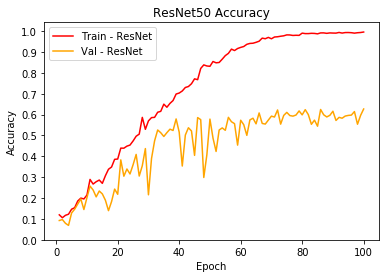

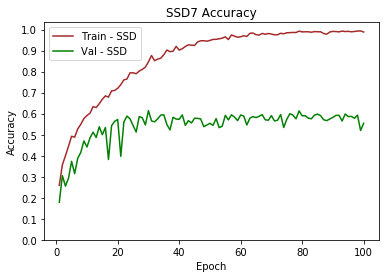

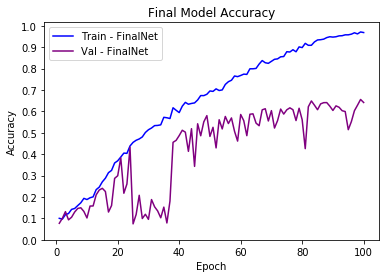

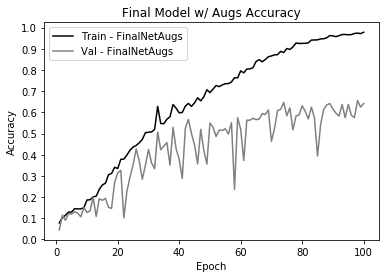

In [9]:
resNet = None
ssd = None
FinalNet = None
FinalNetaugs = None
with open (os.path.join(pp.trainhistory, 'Reshistory.pkl'), 'rb') as fp:     
    resNet = pickle.load(fp)
with open (os.path.join(pp.trainhistory, 'SSDhistory.pkl'), 'rb') as fp2:     
     ssd = pickle.load(fp2)
with open (os.path.join(pp.trainhistory, 'Finalhistory.pkl'), 'rb') as fp3:     
     FinalNet = pickle.load(fp3)
with open (os.path.join(pp.trainhistory, 'Swag2AUGShistory.pkl'), 'rb') as fp4:     
     FinalNetaugs = pickle.load(fp4)
    

# Plot training & validation accuracy values
from matplotlib.ticker import FormatStrFormatter

epochs = 100

x = np.arange(epochs)+1
plt.plot(x, resNet['acc'], color = 'red')
plt.plot(x, resNet['val_acc'], color = 'orange')
# plt.xticks(x)
# plt.xticks([10*i for i in range(0, 11)])
plt.title('ResNet50 Accuracy')
plt.ylabel('Accuracy')
plt.yticks([0.1*i for i in range(0, 11)])
# plt.ylim(0.5, 1.0)
plt.xlabel('Epoch')
plt.legend(['Train - ResNet', 'Val - ResNet'], loc='upper left')
# plt.savefig(os.path.join('output', 'figs', outputName+'-accuracy.png'))
plt.show()

x = np.arange(epochs)+1
plt.plot(x, ssd['acc'], color = 'brown')
plt.plot(x, ssd['val_acc'], color = 'green')
# plt.xticks(x)
# plt.xticks([10*i for i in range(0, 11)])
plt.title('SSD7 Accuracy')
plt.ylabel('Accuracy')
plt.yticks([0.1*i for i in range(0, 11)])
# plt.ylim(0.5, 1.0)
plt.xlabel('Epoch')
plt.legend(['Train - SSD', 'Val - SSD'], loc='upper left')
# plt.savefig(os.path.join('output', 'figs', outputName+'-accuracy.png'))
plt.show()

x = np.arange(epochs)+1
plt.plot(x, FinalNet['acc'], color = 'blue')
plt.plot(x, FinalNet['val_acc'], color = 'purple')
# plt.xticks(x)
# plt.xticks([10*i for i in range(0, 11)])
plt.yticks([0.1*i for i in range(0, 11)])
plt.title('Final Model Accuracy')
plt.ylabel('Accuracy')
# plt.ylim(0.5, 1.0)
plt.xlabel('Epoch')
plt.legend(['Train - FinalNet', 'Val - FinalNet'], loc='upper left')
# plt.savefig(os.path.join('output', 'figs', outputName+'-accuracy.png'))
plt.show()

x = np.arange(epochs)+1
plt.plot(x, FinalNetaugs['acc'], color = 'black')
plt.plot(x, FinalNetaugs['val_acc'], color = 'gray')
# plt.xticks(x)
# plt.xticks([10*i for i in range(0, 11)])
plt.yticks([0.1*i for i in range(0, 11)])
plt.title('Final Model w/ Augs Accuracy')
plt.ylabel('Accuracy')
# plt.ylim(0.5, 1.0)
plt.xlabel('Epoch')
plt.legend(['Train - FinalNetAugs', 'Val - FinalNetAugs'], loc='upper left')
# plt.savefig(os.path.join('output', 'figs', outputName+'-accuracy.png'))
plt.show()

# # Plot training & validation loss values
# plt.plot(x, resNet['loss'])
# plt.plot(x, resNet['val_loss'])
# plt.plot(x, ssd['loss'])
# plt.plot(x, ssd['val_loss'])
# plt.plot(x, SwagNet['loss'])
# plt.plot(x, SwagNet['val_loss'])
# # plt.xticks(x)
# # plt.xticks([10*i for i in range(0, 11)])
# plt.title('Model loss')
# plt.ylabel('Loss')
# # plt.ylim(0, 0.7)
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Val'], loc='upper left')
# # plt.savefig(os.path.join('output', 'figs', outputName+'-loss.png'))
# plt.show()